## Ricker Model estimation with approximated likelihood ratios

Juan Pavez, March 2016.

In this notebook we study the usability of the method [Approximating Likelihood Ratios with Calibrated Discriminative Classifiers](http://inspirehep.net/record/1377273) for times series parameter estimation.




In [1]:
%matplotlib inline
#%load_ext autoreload
#%autoreload 2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import theano
import scipy.linalg as L
import pdb
import pickle
import multiprocessing

import os, sys, inspect
cmd_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0]))
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder + '/../systematics/carl')

import carl

matplotlib.style.use('ggplot')

np.random.seed(1234)

In [14]:
p_value_ = 1
ndims_ = 1
nparams_ = 2
N_ = 50000
T_ = 50

r_value = 3.8
r_bkg = 3.7
sigma_2_value = 0.3
sigma_2_bkg = 0.3
phi_value = 10.
phi_bkg = 9.

bkg_values = (r_bkg, phi_bkg)

shared_r = theano.shared(r_value, name="r")
shared_sigma_2 = theano.shared(sigma_2_value,name="sigma_2")
shared_phi = theano.shared(phi_value, name="phi")
shared_params = [shared_r, shared_phi]

bounds = [(3.5, 3.9), (7.3, 13.)]
n_points = 5

As = np.linspace(bounds[0][0],bounds[0][1], n_points)
Bs = np.linspace(bounds[1][0],bounds[1][1], n_points)
AA, BB = np.meshgrid(As, Bs)
AABB = np.hstack((AA.reshape(-1, 1),
               BB.reshape(-1, 1)))    


In [3]:
class Ricker:
    def sample(self,r=0.5, sigma_2=1., phi=0.1, start=0.1,n_timesteps=1000, rng=None):
        noise = rng.normal(0.,sigma_2, n_timesteps)
        time_serie = np.zeros(n_timesteps,dtype=np.float64)
        time_serie[0] = np.abs(noise[0])
        r_e = np.exp(r)
        #r_e = r
        for i in range(1,n_timesteps):
            time_serie[i] = (r_e*time_serie[i-1]*np.exp(-time_serie[i-1] + noise[i]))

        sampled = np.zeros(n_timesteps)
        sampled = np.array([rng.poisson(phi*time_serie[i]) for i in range(0,n_timesteps,1)])
        
        #return_serie = np.log(time_serie[1:]/(time_serie[:-1]))
        
        return time_serie.reshape(time_serie.shape[0],1), sampled.reshape(sampled.shape[0],1)
    def rvs(self,n_samples, r, sigma_2, phi, random_state=1234):
        rng = np.random.RandomState(random_state) if \
                isinstance(random_state,int) else random_state
        return self.sample(r=r,sigma_2=sigma_2,phi=phi,
                     n_timesteps=n_samples,rng=rng)[1]

In [4]:
p0 = Ricker()
p1 = Ricker()
rng = np.random.RandomState(1234)

n_true = 1000
X_true = np.array([p0.rvs(T_, r_value, sigma_2_value, phi_value, 
                          random_state=np.random.randint(0,5000))
                   for i in range(n_true)])

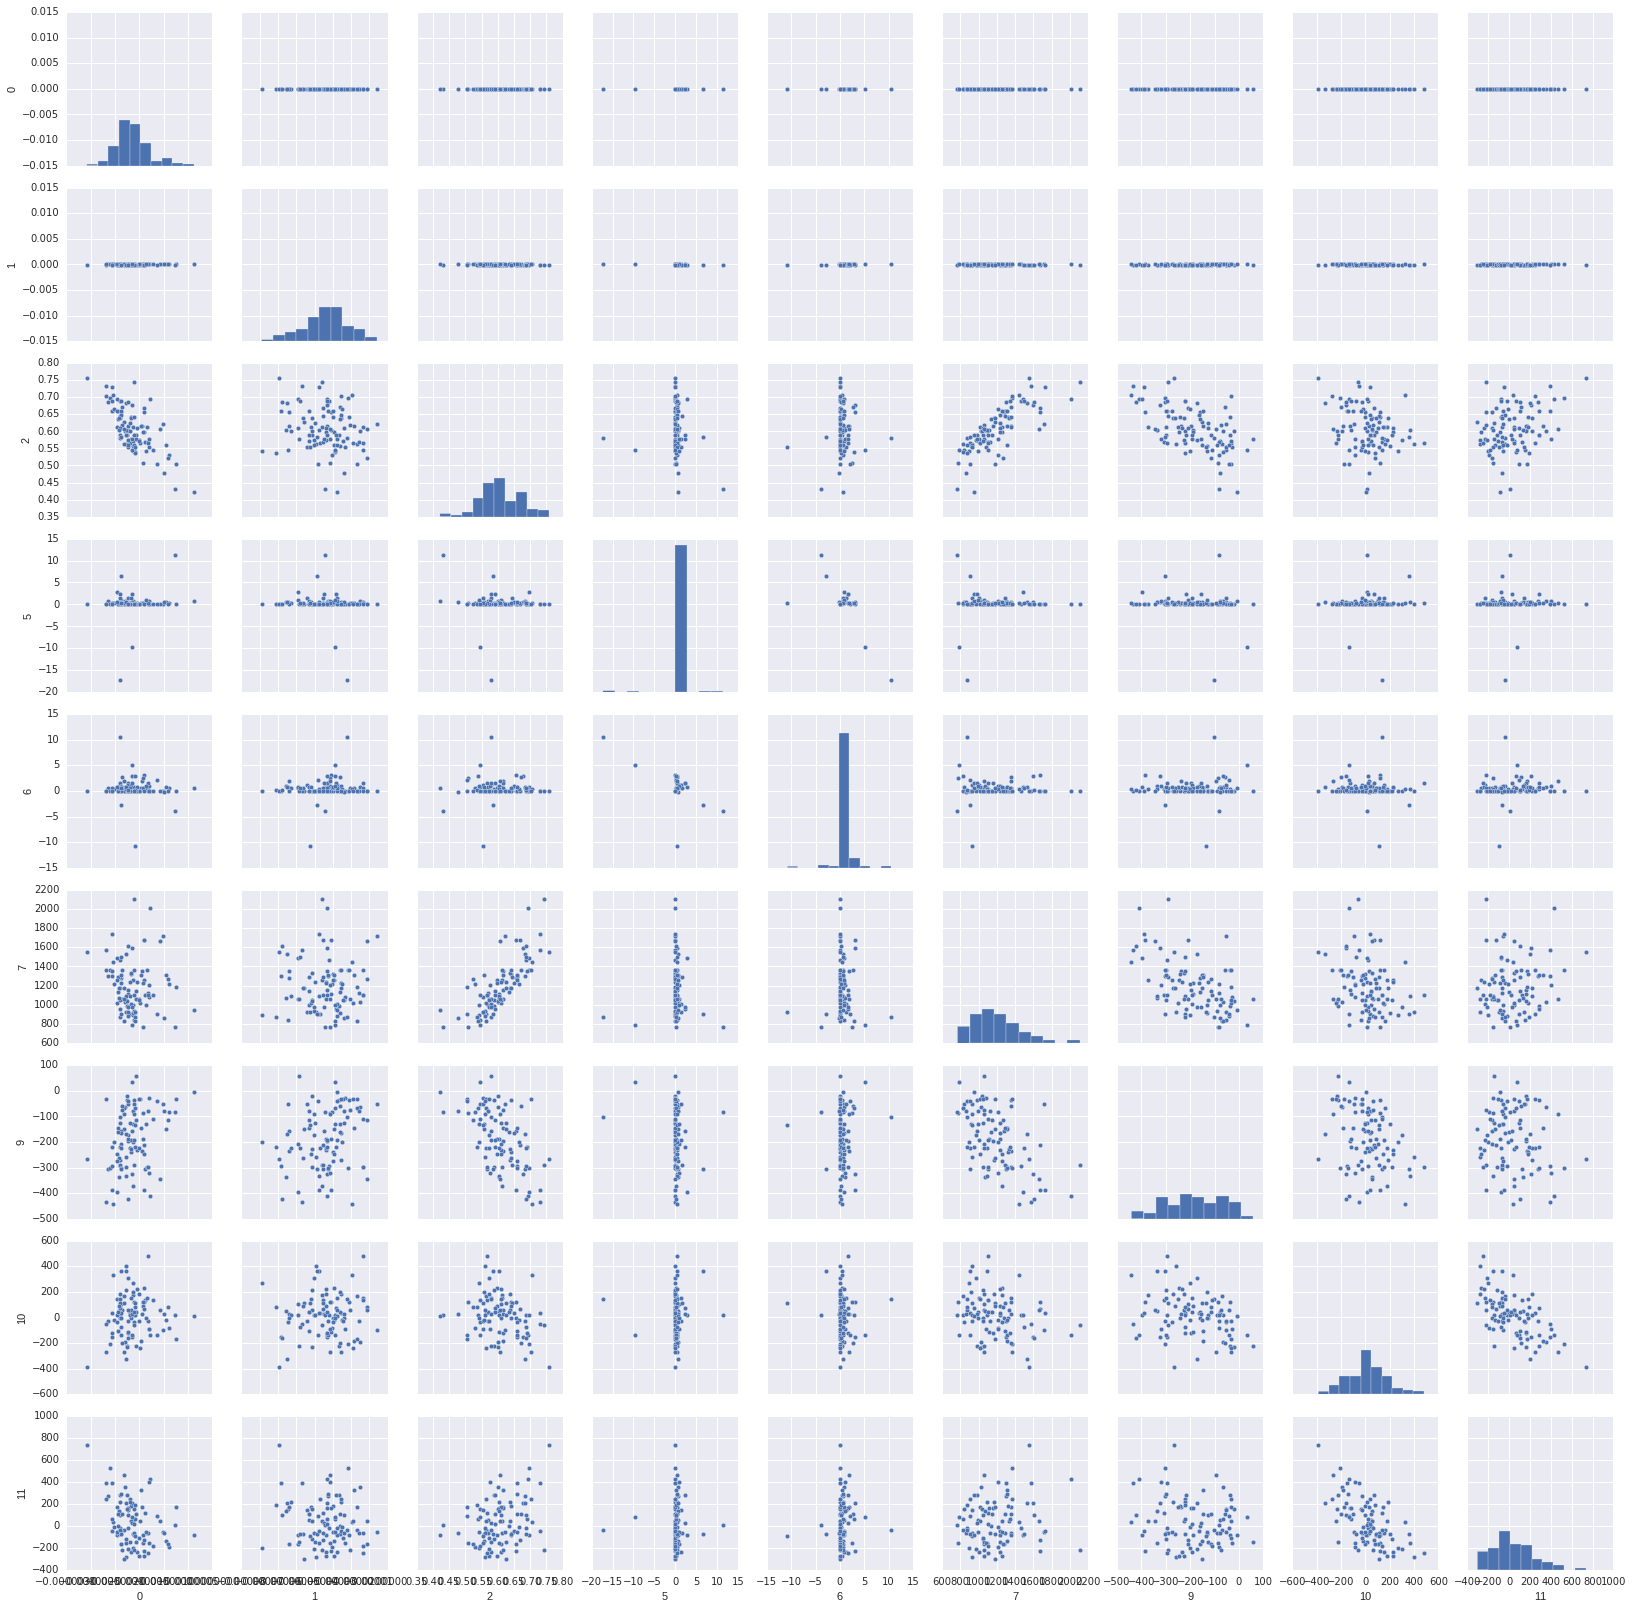

In [28]:
import seaborn
dt = pd.DataFrame(Xs_s[0][:100])
g = seaborn.pairplot(dt, vars=[0,1,2,5,6,7,9,10,11])

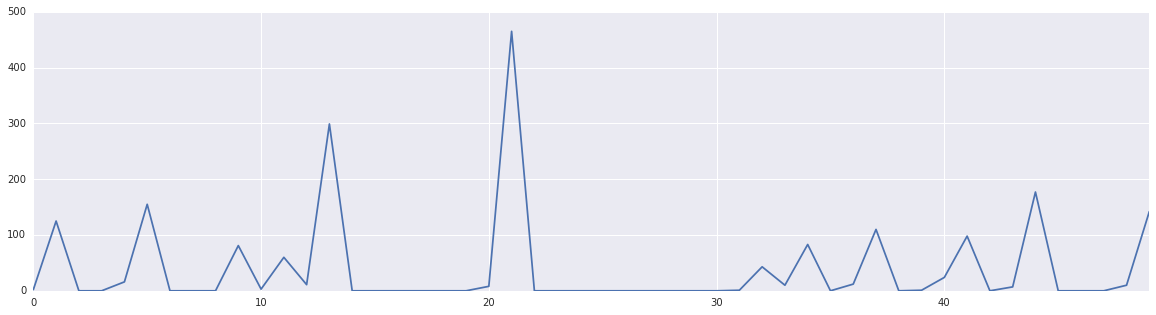

In [29]:
serie1 = X_true[0].flatten()
plt.figure(figsize=(20,5))
#plt.subplot(211)
ts = pd.Series(serie1)
ts[0:500].plot()

In [16]:
from itertools import product
bounds_values = [(np.linspace(bounds[0][0],bounds[0][1], num=n_points)),
                 (np.linspace(bounds[1][0],bounds[1][1], num=n_points))]
combinations = list(product(*bounds_values))

In [7]:
def covariances(X, k, u):
    if len(X.shape) > 1:
        N = X.shape[1]
    else:
        N = X.shape[0]
    return (1./(N-1))* (np.array([(X[:,i+k] - u)*(X[:,i] - u) 
                                      for i in range(N-k)])).sum(axis=0)

# Need to code it for more lags
def differences(X):
    if len(X.shape) > 1:
        X_ = np.zeros((X.shape[0], X.shape[1]-1))
        for k in range(len(X)):
            X_[k] = X[k][1:] - X[k][:-1]
        return X_
    return X[1:] - X[:-1]

def normalize(X):
    if len(X.shape) > 1:
        return X - X.mean(axis=1, keepdims=True)
    return X - X.mean()

# TODO: In the paper Wood doesn't use an itercept term!! (hera I'm using)
def poly_regression(X, y, deg=3):
    reg = np.polyfit(X, y, deg=deg)
    return reg

def poly_autoregression(X_r, X_x, deg=2):
    betas_x = []
    for k in range(X_r.shape[0]):
        keep = ~np.logical_or(np.isnan(X_r[k,:]), np.isnan(X_x[k,:]))
        if np.any(keep):
            X_r_, X_x_ = X_r[k,keep], X_x[k,keep]
            try:
                beta = poly_regression(X_x_, X_r_, deg=deg)
            except ValueError:
                #print('Errors on {0}'.format(k))
                beta = np.array([0.,0.,0.])
        else:
            beta = np.array([0.,0.,0.])
        betas_x.append(beta)
    return np.array(betas_x)

def cubic_regression(y, X, deg=3):
    betas_x = []
    for k in range(X.shape[0]):
        beta = poly_regression(y, X[k], deg=deg)
        betas_x.append(beta)
    return np.array(betas_x)
    
def compute_S(X_true, Xs):
    real = 0
    autoreg_deg = 2
    cubic_deg = 3
    X_true = X_true.reshape(X_true.shape[0], X_true.shape[1])
    Xs = Xs.reshape(Xs.shape[0], Xs.shape[1])
    # Cubic regression on differences
    # Take any X_true as the true value
    X_true_diff = normalize(differences(X_true[real]))
    Xs_diff = normalize(differences(Xs))
    for k in range(Xs_diff.shape[0]):
        Xs_diff[k].sort()
    X_true_diff.sort()
    diff_reg_x = cubic_regression(X_true_diff, Xs_diff, cubic_deg)
    # Assuming regression equal y    
    Xs_true_diff = normalize(differences(X_true))
    for k in range(Xs_true_diff.shape[0]):
        Xs_true_diff[k].sort()
    diff_reg_y = cubic_regression(X_true_diff, Xs_true_diff, cubic_deg)
    # Polynomial Autoregression
    Xs_n = normalize(Xs)
    X_r =  np.array([xs[1:]**0.3 for xs in Xs_n])
    X_x =  np.array([xs[:-1]**0.3 for xs in Xs_n])
    y_n = normalize(X_true)
    y_r =  np.array([xs[1:]**0.3 for xs in y_n])
    y_x =  np.array([xs[:-1]**0.3 for xs in y_n])

    betas_x = poly_autoregression(X_r, X_x, autoreg_deg)
    betas_y = poly_autoregression(y_r, y_x)

    # Autocovariances to lag 5
    u_x = Xs.mean(axis=1)
    covs_x =np.array([covariances(Xs, k, u_x) for k in range(6)])
    u_y = X_true.mean(axis=1)
    covs_y = np.array([covariances(X_true, k, u_y) for k in range(6)])
    # Number of zeros observed
    zeros_x = (Xs == 0.).sum(axis=1)
    zeros_y = (X_true == 0.).sum(axis=1)
    S_x = [np.hstack((diff_reg_x[k], betas_x[k], covs_x[:,k], u_x[k], zeros_x[k]))
           for k in range(Xs.shape[0])]
    S_y = [np.hstack((diff_reg_y[k], betas_y[k], covs_y[:,k], u_y[k], zeros_y[k])) 
           for k in range(X_true.shape[0])]
    return (S_x, S_y)

In [8]:
def produce_data(value):
    value, X_true = value
    X =  np.array([p0.rvs(T_, value[0], sigma_2_value, value[1], 
                           random_state=np.random.randint(0,5000))
                   for i in range(N_//2)])
    X_s, _ = compute_S(X_true, X)
    return X_s

In [ ]:
print('Start producig data')
Xs_s = []
ys = []

num_cores = multiprocessing.cpu_count()
pool = multiprocessing.Pool(num_cores)

values = [v for _,v in enumerate(combinations)]

Xs_s = pool.map(produce_data, [(v, X_true) for v in values])
pool.close()
X1_ = np.array([p1.rvs(T_, r_bkg, sigma_2_bkg, phi_bkg,
                       random_state=np.random.randint(0,5000))
               for i in range(N_//2)])
X1_s, X_true_s = compute_S(X_true, X1_)

print('End producing data')

Start producig data


In [30]:
Xs_s, X1_s, X_true_s = pickle.load(open('data/ricker_data.dat', 'r'))

In [67]:
Xs_s = np.array(Xs_s)
X1_s = np.array(X1_s)
X_true_s = np.array(X_true_s)

25


In [11]:
from carl.ratios import ClassifierRatio
from carl.learning import CalibratedClassifierCV
from carl.learning import as_classifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [17]:
def make_ratio(num):
    X_num = Xs_s[num]
    X_den = X1_s
    X = np.vstack((X_num, X_den))
    y = np.zeros(len(X_num) + len(X_den), dtype=np.int)
    y[len(X_num):] = 1

    clf = ExtraTreesClassifier(n_estimators=40, min_samples_split=20, random_state=0, n_jobs=-1)
    #clf = KerasClassifier(make_model_join, nb_epoch=50, verbose=0)

    cv =  StratifiedShuffleSplit(n_iter=3, test_size=0.5, random_state=1)

    ratio = ClassifierRatio(
        base_estimator=CalibratedClassifierCV(clf, cv=cv, bins=20),
        random_state=0)
    ratio.fit(X, y)
    
    #print('Loss {0} : {1}'.format(num, log_loss(ratio.classifier_.classifiers_[0].
    #               predict(X[:int(len(X)*0.3)]),y[:int(len(X)*0.3)])))
    
    return ratio

In [18]:
print('Start training')
clf_ratios = []

num_cores = multiprocessing.cpu_count()
pool = multiprocessing.Pool(num_cores)

n_sample_points = len(combinations)
points = list(range(n_sample_points))
for i, k in enumerate([points[n:n + num_cores] for n in range(0, n_sample_points, num_cores)]):
    print('Iteration {0}'.format(i))
    clf_ratios += pool.map(make_ratio, points)
#pool.close()
print('End training')


Start training
Iteration 0
Iteration 1
Iteration 2
Iteration 3
End training


In [20]:
llr = []
zeros = []
distances = []

for i, theta in enumerate(combinations):
    print(i, theta)
    ratio = clf_ratios[i]
    ratios = ratio.predict(X_true_s, log=True)
    print ratios[np.isinf(ratios)].shape
    zeros.append(ratios[np.isinf(ratios)].shape[0])
    ratios = ratios[np.logical_and(np.isfinite(ratios),~np.isnan(ratios))]
    nllr = -np.mean(ratios) 
    llr.append(nllr)
    print(llr[-1])

(0, (3.5, 7.2999999999999998))
(1000,)
nan
(1, (3.5, 8.7249999999999996))
(0,)
6.26850361307
(2, (3.5, 10.15))
(0,)
-3.5382069896
(3, (3.5, 11.574999999999999))
(711,)
-0.225485149366
(4, (3.5, 13.0))
(371,)
0.321991450043
(5, (3.6000000000000001, 7.2999999999999998))
(1000,)
nan
(6, (3.6000000000000001, 8.7249999999999996))
(0,)
7.67899463524
(7, (3.6000000000000001, 10.15))
(0,)
-6.05235998401
(8, (3.6000000000000001, 11.574999999999999))
(711,)
0.0203992991622
(9, (3.6000000000000001, 13.0))
(409,)
0.313357441203
(10, (3.7000000000000002, 7.2999999999999998))
(1000,)
nan
(11, (3.7000000000000002, 8.7249999999999996))
(6,)
5.3213875611
(12, (3.7000000000000002, 10.15))
(0,)
-6.82544698233
(13, (3.7000000000000002, 11.574999999999999))
(455,)
0.287207987652
(14, (3.7000000000000002, 13.0))
(455,)
0.441526606387
(15, (3.7999999999999998, 7.2999999999999998))
(1000,)
nan
(16, (3.7999999999999998, 8.7249999999999996))
(0,)
-1.09990255108
(17, (3.7999999999999998, 10.15))
(96,)
-6.9910484

/afs/cern.ch/user/j/jpavezse/.local/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [21]:
llr = np.array(llr)
llr[np.isnan(llr)] = 0.

([9.8333333333333321], [3.8111111111111109])


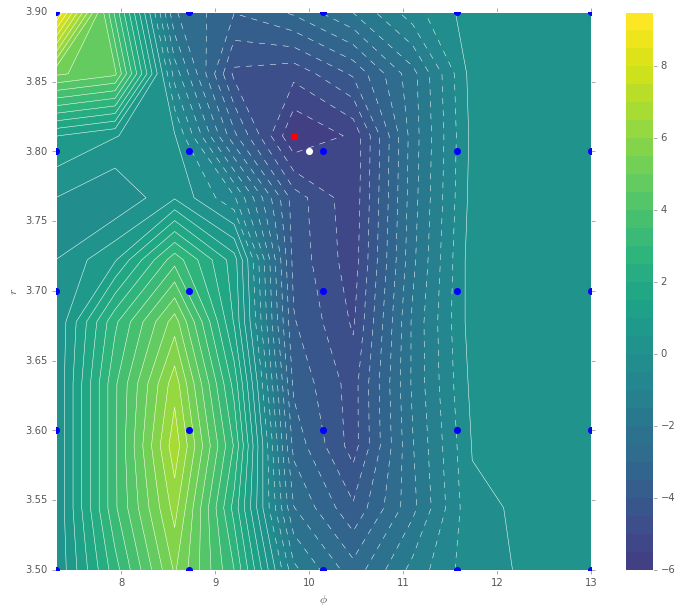

In [22]:
from matplotlib.mlab import griddata
plt.rcParams["figure.figsize"] = (12, 10)

xi = np.linspace(bounds[0][0], bounds[0][1], 10)
yi = np.linspace(bounds[1][0], bounds[1][1], 10)
thetas = np.array([v for v in product(As, Bs)])
zi = griddata(thetas[:, 0], thetas[:, 1], llr, xi, yi, interp='linear')
mle = np.unravel_index(zi.argmin(),zi.shape)
#zi = zi.transpose()
print([yi[mle[0]]], [xi[mle[1]]])
xx, yy = np.meshgrid(xi,yi)

cs = plt.contour(yy, xx, zi, 30, linewidths=0.5, colors='w')
cs = plt.contourf(yy, xx, zi, 30, cmap="viridis",
                 vmax=abs(zi).max(), vmin=-abs(zi).max())
plt.colorbar()  
plt.scatter(thetas[:,1],thetas[:,0], marker='o', c='b', s=50, lw=0, zorder=10)
plt.scatter([phi_value],[r_value], marker='o', c='w', s=50, lw=0, zorder=10)
plt.scatter([yi[mle[0]]], [xi[mle[1]]], marker='o', c='r', s=50, lw=0, zorder=10)

plt.xlim(bounds[1][0], bounds[1][1])
plt.ylim(bounds[0][0], bounds[0][1])
plt.xlabel(r"$\phi$")
plt.ylabel(r"$r$")

([9.8333333333333321], [3.8111111111111109])


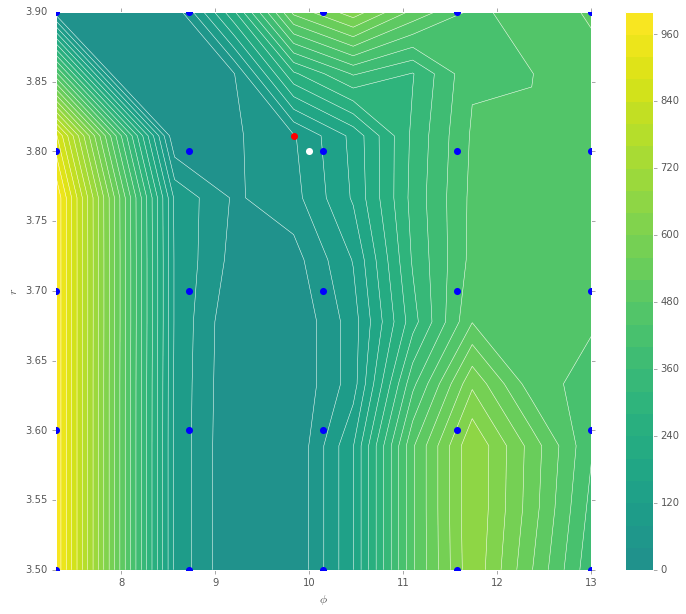

In [23]:
zeros = np.array(zeros)

xi = np.linspace(bounds[0][0], bounds[0][1], 10)
yi = np.linspace(bounds[1][0], bounds[1][1], 10)
thetas = np.array([v for v in product(As, Bs)])
zi = griddata(thetas[:, 0], thetas[:, 1], zeros, xi, yi, interp='linear')
#zi = zi.transpose()
print([yi[mle[0]]], [xi[mle[1]]])
xx, yy = np.meshgrid(xi,yi)

cs = plt.contour(yy, xx, zi, 30, linewidths=0.5, colors='w')
cs = plt.contourf(yy, xx, zi, 30, cmap="viridis",
                 vmax=abs(zi).max(), vmin=-abs(zi).max())
plt.colorbar()  
plt.scatter(thetas[:,1],thetas[:,0], marker='o', c='b', s=50, lw=0, zorder=10)
plt.scatter([phi_value],[r_value], marker='o', c='w', s=50, lw=0, zorder=10)
plt.scatter([yi[mle[0]]], [xi[mle[1]]], marker='o', c='r', s=50, lw=0, zorder=10)

plt.xlim(bounds[1][0], bounds[1][1])
plt.ylim(bounds[0][0], bounds[0][1])
plt.xlabel(r"$\phi$")
plt.ylabel(r"$r$")
#plt.savefig('plots/ricker_zeros.pdf')
plt.show()

[  3.75306122  10.09183673]


/afs/cern.ch/user/j/jpavezse/.local/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:304: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


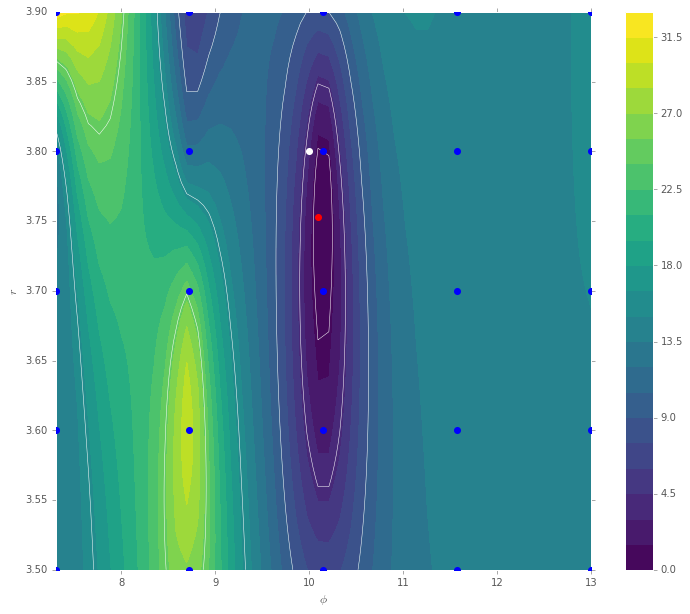

In [24]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, Matern

thetas = np.array([v for v in product(As, Bs)])

gp = GaussianProcessRegressor(alpha=0., normalize_y=True, 
                              kernel=C(1.0) * Matern(1.0, length_scale_bounds="fixed"))
gp.fit(thetas, llr)

xi = np.linspace(bounds[0][0], bounds[0][1], 50)
yi = np.linspace(bounds[1][0], bounds[1][1], 50)
    
xx, yy = np.meshgrid(xi, yi)
zz, std = gp.predict(np.c_[xx.ravel(), yy.ravel()], return_std=True)
zi = zz.reshape(xx.shape)

mle_2 = np.unravel_index(zi.argmin(),zi.shape)
zi -= zi[mle_2]
print(np.c_[xx.ravel(), yy.ravel()][zi.argmin()])
zi *= 2.
zi = zi.transpose()
#zi = np.flipud(zi.transpose())

cs = plt.contour(yi, xi, zi, [1.,4.,9.,16.,25.], linewidths=0.5, colors='w')
cs = plt.contourf(yi, xi, zi, 30, cmap="viridis",
                  vmax=abs(zi).max(), vmin=0.0)
#plt.clabel(cs, inline=1, fontsize=10)

plt.colorbar()
plt.scatter(thetas[:,1],thetas[:,0], marker='o', c='b', s=50, lw=0, zorder=10)
plt.scatter([yi[mle_2[0]]], [xi[mle_2[1]]], marker='o', c='r', s=50, lw=0, zorder=10)
plt.scatter([phi_value],[r_value], marker='o', c='w', s=50, lw=0, zorder=10)
#plt.scatter([theta[theta1, 1]], [theta[theta1, 2]], marker='o', c='r', s=50, lw=0, zorder=10)

plt.xlim(bounds[1][0], bounds[1][1])
plt.ylim(bounds[0][0], bounds[0][1])
plt.xlabel(r"$\phi$")
plt.ylabel(r"$r$")

In [25]:
from carl.ratios.utils import plot_scores

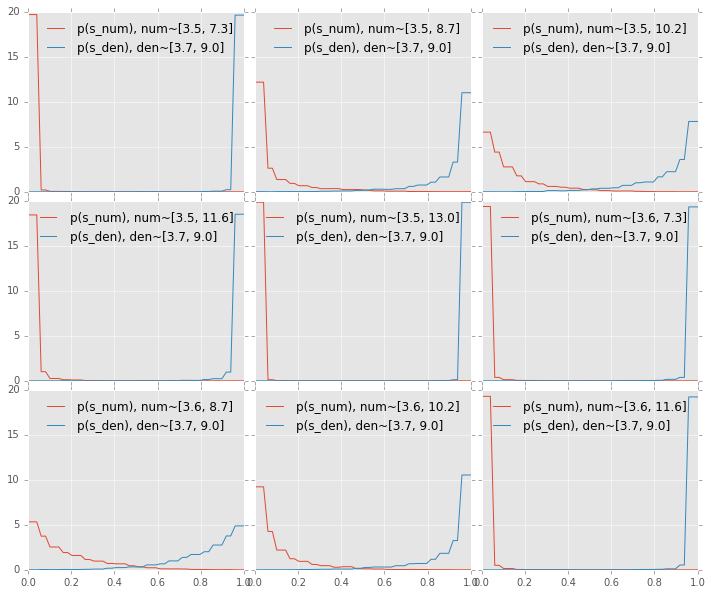

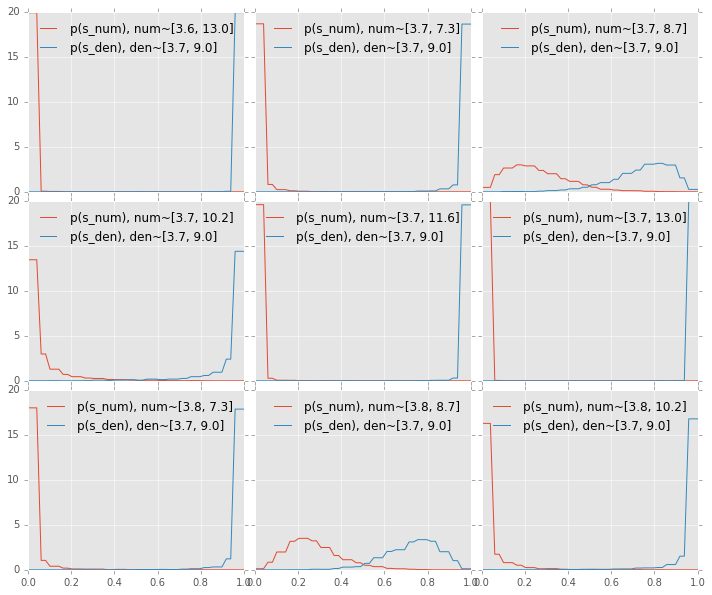

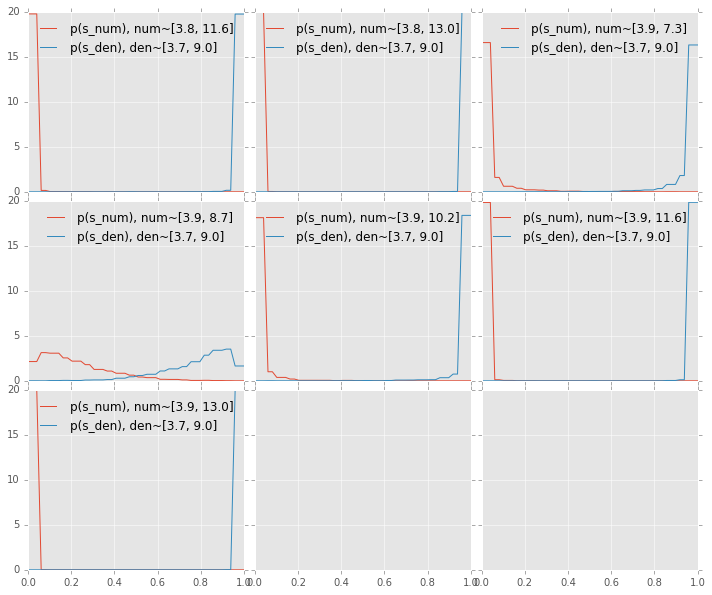

In [27]:
plot_scores(clf_ratios[:9],
           [(t,bkg_values) for t in thetas[:9]])
plot_scores(clf_ratios[9:18],
           [(t,bkg_values) for t in thetas[9:18]])
plot_scores(clf_ratios[18:27],
           [(t,bkg_values) for t in thetas[18:25]])

TO-DO:
* 2D parameter estimation.
* Parameter estimation on $Y_t$ (here the method must be adapted for state space models).

* Check with other parameters
* Try with an easier model e.g simple autoregresive model